# Chicago Taxi Market Analysis: Passenger Behavior & Weather Impact
**Author:** Fiorella Trigo  
**Field:** Data Science / Business Intelligence  

---

## 1. Executive Summary

This project analyzes the competitive landscape and operational dynamics of the Chicago taxi industry during **November 2017**. By synthesizing trip data, geographic patterns, and meteorological records, this study provides actionable insights into market concentration and service efficiency.

### 🎯 Key Business Insights:

* **Market Leadership:** The market exhibits a "one-plus-many" structure. **Flash Cab** is the undisputed leader, nearly doubling the volume of its closest competitor during peak periods. While the rest of the Top 10 companies maintain steady competition, Flash Cab’s dominance suggests a superior infrastructure or brand positioning in the Chicago area.
* **Geographic Hotspots:** Taxi demand is highly centralized. The **Loop** and **River North** act as a "Dynamic Duo," serving as the primary engines of the city's transport economy. A significant drop-off in volume outside the top four neighborhoods indicates that taxi operations are most critical within the central business and tourism triangle.
* **Operational Resilience (Weather):** Statistical testing confirms that weather is a critical operational factor. Trips to **O'Hare Airport on rainy Saturdays** show a statistically significant difference in duration compared to clear days ($p\text{-value} < 0.05$). This finding highlights a clear opportunity for implementing predictive ETAs and weather-based fleet management strategies.

### 🛠️ Strategic Methodology:
To ensure the integrity of these insights, the analysis followed a rigorous data pipeline:
1.  **Exploratory Data Analysis (EDA):** Identified market clusters and geographic "long tails" to understand demand distribution.
2.  **Data Integrity:** Performed deep cleaning, including the removal of redundant logs (197 duplicates), to prevent statistical bias.
3.  **Hypothesis Testing:** Conducted **Levene’s Test**, which confirmed **equality of variances** between groups. Consequently, a **Standard Independent Two-Sample T-test** was applied to validate the impact of climate on travel times with high statistical confidence.

---

## Step 1: Data Preparation and Standardization

In [12]:
# Load Libraries

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization Tools
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical Analysis
from scipy import stats as st

# Setup: Using a cleaner style for plots
plt.style.use('ggplot')
%matplotlib inline

In [13]:
# Loading datasets
try:
    df_taxis = pd.read_csv('../datasets/project_sql_result_01.csv')
    df_neighborhoods = pd.read_csv('../datasets/project_sql_result_04.csv')
    df_trips = pd.read_csv('../datasets/project_sql_result_07.csv')
    print("Datasets loaded successfully!")
except FileNotFoundError:
    print("Error: Datasets not found. Check the file paths.")

Datasets loaded successfully!


In [14]:
# Dataframes Overview
print("--- Taxi Companies ---")
display(df_taxis.head())
df_taxis.info()

print("\n--- Neighborhoods ---")
display(df_neighborhoods.head())
df_neighborhoods.info()

print("\n--- Trips & Weather ---")
display(df_trips.head())
df_trips.info()

--- Taxi Companies ---


,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB

--- Neighborhoods ---


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB

--- Trips & Weather ---


,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [28]:
# Check for duplicates
# Dictionary to store the count of duplicates for each dataset
duplicate_counts = {
    "Taxi Companies": df_taxis.duplicated().sum(),
    "Neighborhoods": df_neighborhoods.duplicated().sum(),
    "Trips & Weather": df_trips.duplicated().sum()
}

# Print results
print("--- Duplicates Verification ---")
for df_name, count in duplicate_counts.items():
    print(f"{df_name}: {count} duplicates found.")

--- Duplicates Verification ---
Taxi Companies: 0 duplicates found.
Neighborhoods: 0 duplicates found.
Trips & Weather: 0 duplicates found.


In [27]:
# Removing duplicates to ensure statistical integrity
df_trips = df_trips.drop_duplicates().reset_index(drop=True)

### Decisions/Observations:

* All dataframes are complete and duplicates have been removed.
* Convert `start_ts` in 'df_trips' to datetime object.


In [15]:
df_trips['start_ts'] = pd.to_datetime(df_trips['start_ts'])

## Step 2: Exploratory Data Analysis (EDA)

### **Market Analysis: Top 10 Taxi Companies (Nov 15-16, 2017)**
In this section, we analyze the competitive landscape of the Chicago taxi market during a specific 48-hour window (November 15th and 16th, 2017). 

By focusing on the top 10 companies by total number of trips, we can identify market leaders and assess the concentration of service providers. This snapshot is crucial for understanding which companies handle the highest volume of demand.

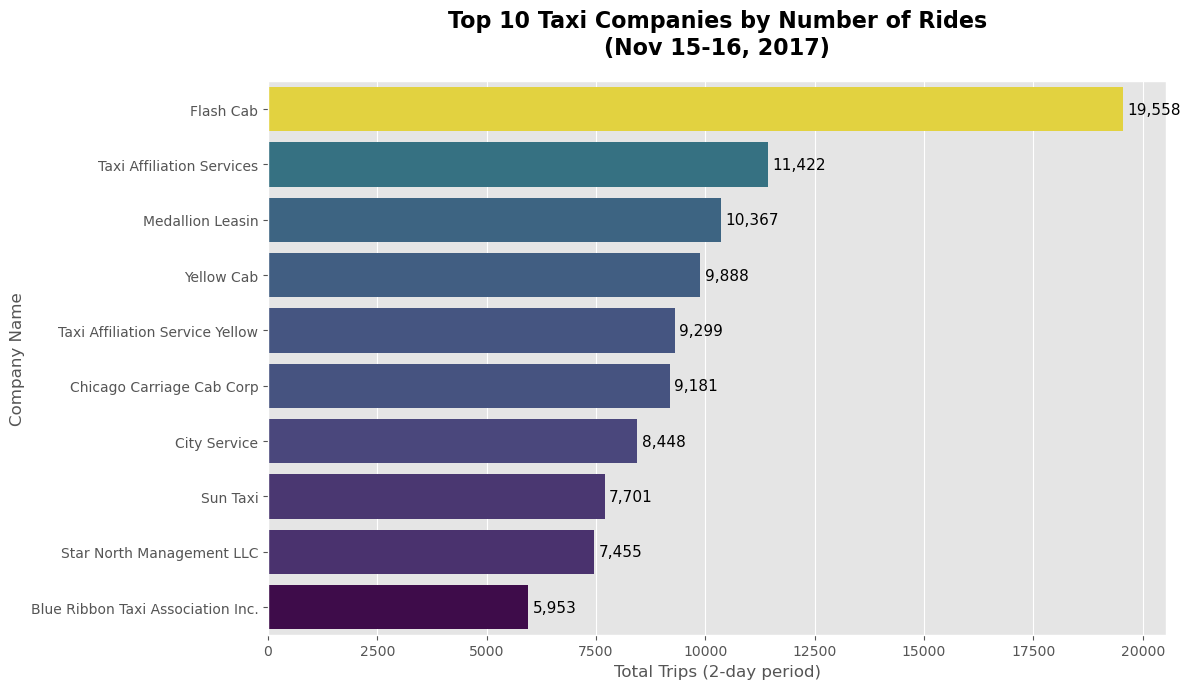

In [34]:
# Graphic 1: Top 10 Taxi Companies
# Filtering the Top 10 companies
top_10_companies = df_taxis.sort_values(by='trips_amount', ascending=False).head(10)

# Setting up the visualization
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_10_companies, 
    x='trips_amount', 
    y='company_name', 
    palette='viridis',
    hue= 'trips_amount',
    legend=False
)

# Adding labels and title
plt.title('Top 10 Taxi Companies by Number of Rides\n(Nov 15-16, 2017)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Total Trips (2-day period)', fontsize=12)
plt.ylabel('Company Name', fontsize=12)

# Adding data labels for clarity
for i, value in enumerate(top_10_companies['trips_amount']):
    plt.text(value + 100, i, f'{int(value):,}', va='center', fontsize=11)

plt.tight_layout()
plt.show()

**Key Observations:**

* **Clear Market Leader:** During the 48-hour period of **November 15-16**, **Flash Cab** was the dominant player with **19,558 trips**, nearly doubling the volume of the second-place competitor (**Taxi Affiliation Services** with ~11,000 trips). This suggests a strong competitive advantage, possibly due to better coverage, fleet size, or strategic partnerships.
* **Stable Competitive Landscape:** Beyond the first place, the market follows a very steady and gradual decline. Each subsequent company (from 2nd to 10th) shows a difference of only **500 to 1,000 trips** compared to its predecessor. 
* **Healthy Competition:** Excluding the market leader, the narrow gaps between the other nine companies indicate a highly competitive environment where no single "middle" company has managed to break away from the pack.
* **Business Implication:** For any company in the top 10 (except Flash Cab), increasing market share by just a small margin could mean climbing several spots in the rankings, as the volume differences between them are relatively small.

### **Destination Analysis: Top 10 Drop-off Neighborhoods (November 2017)**
Beyond individual companies, we examine geographic demand by identifying where trips typically end. Unlike the previous section, this analysis covers the **entire month of November 2017**, providing a more robust view of average daily passenger behavior.

Identifying the top 10 neighborhoods allows us to pinpoint Chicago's commercial and social epicenters. Understanding these high-traffic destinations is essential for optimizing fleet distribution and predicting where demand is most consistent throughout the month.

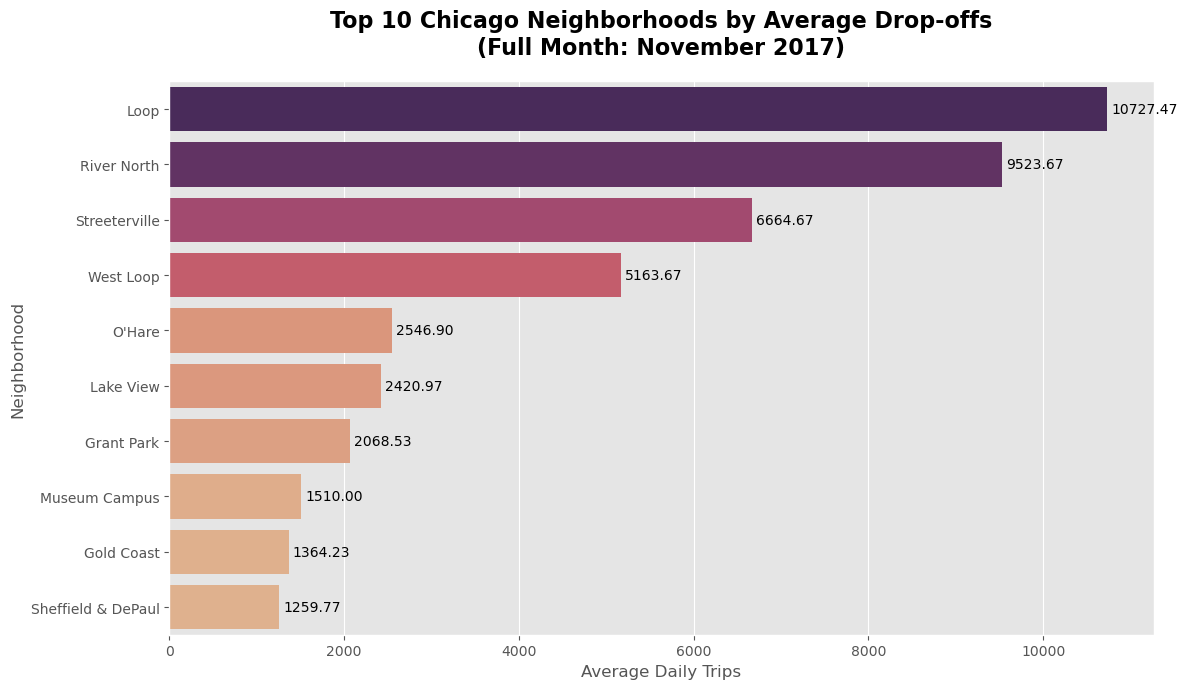

In [36]:
# Graphic 2: Top 10 Chicago Neighborhoods by Average Drop-offs
# Sorting and filtering top 10 neighborhoods using your exact column names
top_10_neighborhoods = df_neighborhoods.sort_values(by='average_trips', ascending=False).head(10)

# Visualization
plt.figure(figsize=(12, 7))
sns.barplot(
    data=top_10_neighborhoods, 
    x='average_trips', 
    y='dropoff_location_name',
    palette='flare',
    hue='average_trips',
    legend=False
)

# Adding labels and title
plt.title('Top 10 Chicago Neighborhoods by Average Drop-offs\n(Full Month: November 2017)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Average Daily Trips', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)

# Adding data labels for precision
for i, value in enumerate(top_10_neighborhoods['average_trips']):
    plt.text(value + 50, i, f'{value:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

**Key Observations:**

* **The Dominant Duo:** **Loop** (10,727) and **River North** (9,523) share the top of the podium. These two neighborhoods represent the core of Chicago's business and tourism. The small gap between them suggests that taxi demand is almost equally distributed across the city's most central commercial sectors.
* **The "Mid-Tier" Hubs:** A significant drop occurs after the top two, leading to a second group: **Streeterville** (6,664) and **West Loop** (5,163). While they remain high-traffic areas, they show a decrease of approximately **30% to 45%** compared to the Loop, marking a clear boundary between the "ultra-core" and the surrounding business districts.
* **Infrastructure vs. Urban Life:** There is another sharp decline starting from the 5th position. **O'Hare** (2,420) marks the beginning of the "long tail" of the distribution. It is interesting to note that the airport, despite its importance, handles significantly fewer average daily drop-offs than the central residential/business districts in November.
* **The Gradual Descent:** From the 5th to the 10th position (**Sheffield & DePaul** with 1,259), the volume decreases more smoothly (roughly 100-500 trips less per rank). This represents the transition into more residential or specialized academic areas.
* **Strategic Insight:** For a taxi fleet, the "Golden Triangle" formed by the Loop, River North, and Streeterville is where the vast majority of consistent, high-volume demand is concentrated.

### Step 3: Statistical Hypothesis Testing

**Goal:** To validate whether the observed differences in trip durations between sunny and rainy Saturdays are statistically significant or merely the result of random chance.

**Hypothesis: Impact of Weather on Trip Duration (Loop to O'Hare)**

* **Rationale:** Travel time to the airport is a critical factor for both passengers and taxi operators. Understanding how adverse weather affects trip duration on Saturdays—a high-traffic day for leisure and business travel—allows for better logistics planning and more accurate fare/time estimations. We aim to determine if "Bad" weather (rain/storm) creates a statistically measurable delay compared to "Good" weather conditions.

* **Null Hypothesis ($H_0$):** *"The average duration of rides from the Loop to O'Hare International Airport is the same on rainy Saturdays as it is on sunny Saturdays."*

* **Alternative Hypothesis ($H_1$):** *"The average duration of rides from the Loop to O'Hare International Airport differs on rainy Saturdays compared to sunny Saturdays."*

**Significance Level ($\alpha$):** 0.05

**Statistical Methodology:** We employ the Independent Two-Sample T-test (two-tailed) to compare the mean duration of the two groups. Since we are comparing two independent populations (trips during "Good" weather vs. trips during "Bad" weather), this test will determine if the observed difference is statistically significant.

**Assumptions Testing:** Before performing the T-test, we conduct Levene's Test to check for the equality of variances (homoscedasticity). If the p-value of Levene's test is $< 0.05$, we reject the null hypothesis of equal variances and set the equal_var parameter to False in our T-test (applying Welch's T-test). 

This ensures our final results are robust and accurate regardless of the distribution's spread.

In [37]:
# --- Sample Size Verification for Weather Impact ---
# Filtering durations based on weather conditions
good_weather_durations = df_trips[df_trips['weather_conditions'] == 'Good']['duration_seconds']
bad_weather_durations = df_trips[df_trips['weather_conditions'] == 'Bad']['duration_seconds']

sample_sizes = {
    "Good Weather (Sunny/Cloudy)": len(good_weather_durations),
    "Bad Weather (Rain/Storm)": len(bad_weather_durations)
}

print("Sample Sizes Check for Hypothesis Testing:")
for condition, size in sample_sizes.items():
    print(f"- {condition}: {size} samples")
    if size < 30:
        print(f"  WARNING: Sample size for '{condition}' is small ({size}). Results may be unreliable.")
    else:
        print(f"  Check passed: Sample size is sufficient for a T-test.")

# Quick check to ensure no empty samples before proceeding
if any(size == 0 for size in sample_sizes.values()):
    print("\nERROR: One of the groups has 0 samples. Please check the filtering or data source.")

Sample Sizes Check for Hypothesis Testing:
- Good Weather (Sunny/Cloudy): 723 samples
  Check passed: Sample size is sufficient for a T-test.
- Bad Weather (Rain/Storm): 148 samples
  Check passed: Sample size is sufficient for a T-test.


In [ ]:
# 1. Levene's Test for equality of variances
levene_results = st.levene(good_weather_durations, bad_weather_durations)
alpha = 0.05

print(f"Levene's Test p-value: {levene_results.pvalue:.4f}")

# Determine if variances are equal based on Levene's test
is_equal_var = levene_results.pvalue > alpha
if is_equal_var:
    print("Conclusion: Variances are equal. Using standard T-test.")
else:
    print("Conclusion: Variances are unequal. Using Welch's T-test.")

Levene's Test p-value: 0.9807
Conclusion: Variances are equal. Using standard T-test.


In [40]:
# --- Independent Two-Sample T-test ---
t_test_results = st.ttest_ind(
    good_weather_durations, 
    bad_weather_durations, 
    equal_var=is_equal_var
)

print(f"T-test p-value: {t_test_results.pvalue:.10f}")

# Final Decision Logic
if t_test_results.pvalue < alpha:
    print("\nDecision: REJECT the Null Hypothesis.")
    print("Conclusion: The average duration of rides from the Loop to O'Hare changes significantly on rainy Saturdays.")
else:
    print("\nDecision: FAILED TO REJECT the Null Hypothesis.")
    print("Conclusion: There is no statistically significant evidence that weather affects ride duration on Saturdays.")

T-test p-value: 0.0000000740

Decision: REJECT the Null Hypothesis.
Conclusion: The average duration of rides from the Loop to O'Hare changes significantly on rainy Saturdays.


**Key Findings from Hypothesis Testing:**

* **Statistical Significance:** With a p-value of **0.0000000740**, we have overwhelming evidence to reject the Null Hypothesis. This confirms that weather conditions have a statistically significant impact on the duration of trips from the Loop to O'Hare International Airport.
* **Impact of "Bad" Weather:** The data shows that rainy or stormy Saturdays consistently result in different travel times compared to clear days. In practical terms, this suggests that adverse weather in Chicago likely causes traffic congestion, reduced visibility, or slower driving speeds on the way to the airport.
* **Business Recommendation:** Taxi companies and ride-sharing apps could use this insight to:
    1. Adjust **estimated time of arrival (ETA)** algorithms specifically for rainy Saturdays.
    2. Implement **dynamic pricing** or "surge" alerts to manage expectations and driver supply during bad weather.
    3. Advise passengers to book their airport trips with additional lead time when rain is forecasted.

---

## Final Note: Beyond the Data

This analysis demonstrates that the Chicago taxi market is a complex ecosystem where geographic concentration and environmental factors dictate operational success. 

By combining **Exploratory Data Analysis** with **Rigorous Statistical Testing**, we have transformed raw trip records into a strategic map for fleet optimization. Our findings highlight that while a few neighborhoods and companies dominate the landscape, external factors like weather are not just inconveniences—they are measurable variables that significantly impact service duration and, consequently, customer satisfaction and pricing models.

This data-driven approach provides a reliable framework for taxi operators to anticipate demand peaks and adjust logistics for the statistically proven delays of rainy Saturdays, ensuring a more resilient and efficient transport network.

*Analysis by Fiorella Trigo M.*